# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb../xvfb: line 24: start-stop-daemon: command not found
.


2022-02-19 15:03:48.913 python[3345:122716] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa8f4c97900>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-02-19 15:03:48.914 python[3345:122716] Warning: Expected min height of view: (<NSButton: 0x7fa8f7091360>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-02-19 15:03:48.916 python[3345:122716] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa8f7094850>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-02-19 15:03:48.919 python[3345:122716] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa8f709ee70>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


state vector dim = 4
n_actions = 2


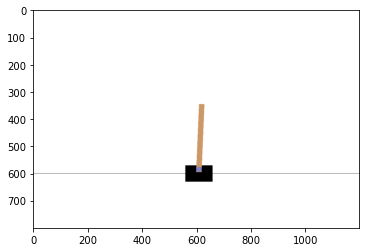

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [3]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [4]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s]).reshape((env.action_space.n,))

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(env.action_space.n, p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [5]:
dummy_states, dummy_actions, dummy_reward = 

print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-0.00528252  0.03692348  0.01512566  0.02109932]
 [-0.00454405 -0.15841209  0.01554764  0.31851593]
 [-0.00771229 -0.35375198  0.02191796  0.61606118]
 [-0.01478733 -0.54917319  0.03423919  0.91556595]
 [-0.0257708  -0.74474103  0.0525505   1.21881013]]
actions: [0, 0, 0, 0, 0]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [6]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = []
    elite_actions = []
    
    for i, r in enumerate(rewards_batch):
        if r >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])

    return elite_states, elite_actions

# Training loop
Generate sessions, select N best and fit to those.

In [7]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = 256.860, threshold=279.600


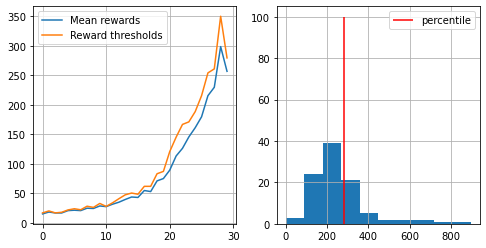

You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

In [9]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

# Results

In [11]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]

2022-02-19 15:25:16.952 python[3345:122716] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa8f9999730>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-02-19 15:25:16.952 python[3345:122716] Warning: Expected min height of view: (<NSButton: 0x7fa8f7dcb770>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-02-19 15:25:16.956 python[3345:122716] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa8f999dd10>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-02-19 15:25:16.959 python[3345:122716] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fa8f99b27a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


In [12]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (2 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


### 1.1

In [32]:
import gym
import numpy as np

env = gym.make("Taxi-v3")
env.reset()
env.render()

n_states = env.observation_space.n
n_actions = env.action_space.n

def initialize_policy(n_states, n_actions):
    policy = np.ones((n_states, n_actions)) / n_actions
    
    return policy

policy = initialize_policy(n_states, n_actions)

def generate_session(env, policy, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):
        # Hint: you can use np.random.choice for sampling action
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
        a = np.random.choice(np.arange(n_actions), p=policy[s])

        new_s, r, done, info = env.step(a)

        # Record information we just got from the environment.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break

    return states, actions, total_reward

def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = []
    elite_actions = []
    
    for i, r in enumerate(rewards_batch):
        if r >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])

    return elite_states, elite_actions

def get_new_policy(elite_states, elite_actions):
    """
    Given a list of elite states/actions from select_elites,
    return a new policy where each action probability is proportional to

        policy[s_i,a_i] ~ #[occurrences of s_i and a_i in elite states/actions]

    Don't forget to normalize the policy to get valid probabilities and handle the 0/0 case.
    For states that you never visited, use a uniform distribution (1/n_actions for all states).

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])
    
    for s, a in zip(elite_states, elite_actions) :
        new_policy[s, a] += 1
    new_policy[new_policy.sum(axis=1) == 0] = 1
    new_policy = new_policy / new_policy.sum(axis=1, keepdims=True)

    return new_policy

from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])
    
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()


def train(n_sessions = 250, percentile = 50, learning_rate = 0.5):
    policy = initialize_policy(n_states, n_actions)
    
    log = []
    
    for i in range(100):
        sessions = [generate_session(env, policy) for _ in range(n_sessions)]

        states_batch, actions_batch, rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

        new_policy = get_new_policy(elite_states, elite_actions)

        policy = learning_rate * new_policy + (1 - learning_rate) * policy

        # display results on chart
        show_progress(rewards_batch, log, percentile)

    return np.mean(rewards_batch)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



mean reward = -746.388, threshold=14.000


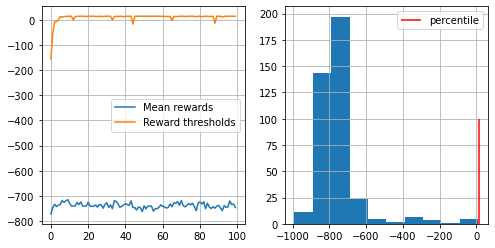

In [35]:
percentiles = np.linspace(0, 100, 11)
ns_sessions = np.linspace(50, 400, 15)
learning_rate = 0.5
''

stats = np.zeros((len(percentiles), len(ns_sessions)))
for i_p, percentile in enumerate(percentiles):
    for j_s, n_sessions in enumerate(ns_sessions):
        mean_reward = train(int(n_sessions), percentile, learning_rate)
        stats[i_p][j_s] = mean_reward

In [37]:
stats

array([[-5.96220000e+02, -5.98520000e+02, -5.87140000e+02,
        -6.70432000e+02, -5.33506667e+02, -7.33725714e+02,
        -7.54360000e+02, -7.24360000e+02, -5.80636000e+02,
        -6.47341818e+02, -6.68293333e+02, -7.32947692e+02,
        -6.64960000e+02, -6.60306667e+02, -7.25602500e+02],
       [-2.55200000e+02, -2.05920000e+02, -2.13750000e+02,
        -2.60608000e+02, -1.63013333e+02, -2.15754286e+02,
        -1.07490000e+02, -2.06408889e+02, -9.00760000e+01,
        -1.56727273e+00, -4.14666667e+00, -1.03230769e+02,
        -2.04662857e+02, -1.71869333e+02, -7.46325000e+01],
       [-7.44000000e+01, -1.68840000e+02, -1.14100000e+02,
        -2.00808000e+02, -1.06733333e+01, -3.75428571e+00,
        -5.48000000e+00, -6.27555556e+00, -1.06820000e+02,
         1.00000000e+00,  1.84000000e+00,  5.13846154e-01,
         2.04285714e+00,  2.27200000e+00,  3.15750000e+00],
       [-1.47100000e+02, -1.90373333e+02, -7.15600000e+01,
        -7.43920000e+01, -9.58800000e+01, -2.74457143

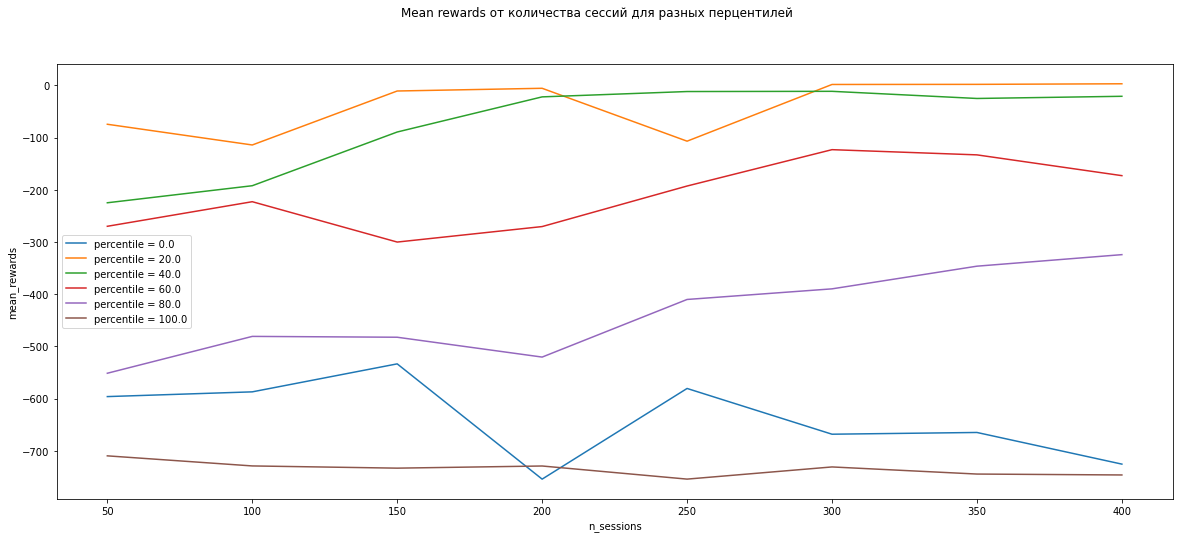

In [58]:
fig = plt.figure(figsize=[20, 8])
for i in range(0, len(percentiles), 2):
    plt.plot(ns_sessions[::2], stats[i][::2], label=f'percentile = {percentiles[i]}')
    plt.xlabel('n_sessions')
    plt.ylabel('mean_rewards')
    plt.legend()
    plt.grid()
    
fig.suptitle('Mean rewards от количества сессий для разных перцентилей')
plt.show()

1) Обучать модель с перцентилем 0 очень плохо, тк мы смотрим не на элиту, а на всё "множество".  
2) Интересно, что обучать с перцентилем 100 при этом даже хуже, чем учиться на рандоме (перцентиль 0). Скорее всего это можно объяснить тем, что мы учимся только на некоторых точках, не учитывая оставшиеся точки, за счёт которых reward становится меньше.  
3) Для данной задачи лучше всего было бы взять перцентиль 20.  
4) Хочется также отметить, что при увеличении количества сессий средняя награда выходит на плато.

### 1.2

mean reward = 1.150, threshold=2.800


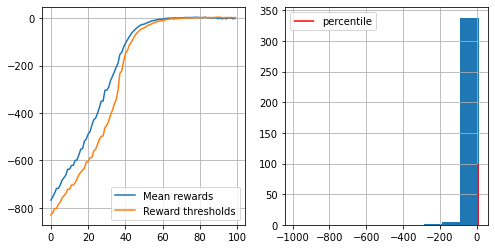

In [54]:
percentile = 20
n_sessions = 400
learning_rate = 0.5

mean_reward = train(n_sessions, percentile, learning_rate)

In [57]:
print("mean_reward =", mean_reward, "is positive! WIN!")

mean_reward = 1.15 is positive! WIN!


# Homework part II

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (up to 6 pts) Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling. (2 pts)
  * Try re-using samples from 3-5 last iterations when computing threshold and training. (2 pts)
  * Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2` (2 pts). Feel free to experiment with hyperparameters, architectures, schedules etc.
  
__Please list what you did in Anytask submission form__. This reduces probability that somebody misses something.
  
  
### Tips
* Gym page: [MountainCar](https://gym.openai.com/envs/MountainCar-v0), [LunarLander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

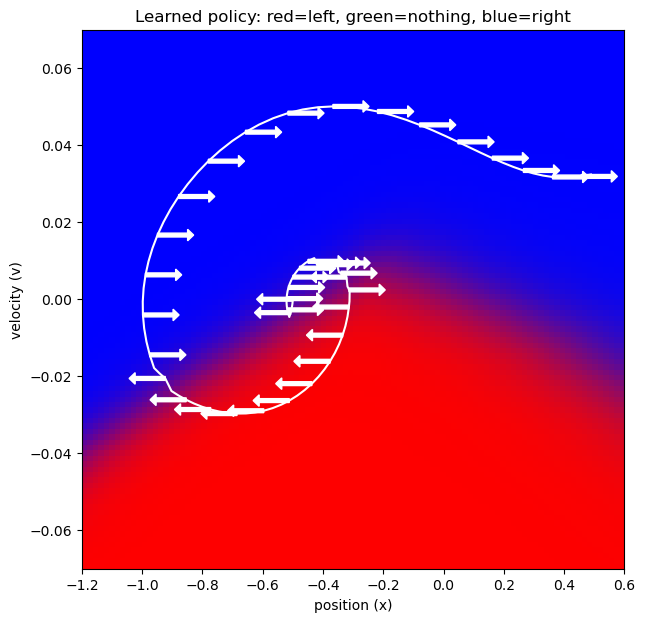

In [ ]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    
    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(probs, extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed), aspect='auto')
    ax.set_title('Learned policy: red=left, green=nothing, blue=right')
    ax.set_xlabel('position (x)')
    ax.set_ylabel('velocity (v)')
    
    # Sample a trajectory and draw it
    states, actions, _ = generate_session(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color='white')
    
    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color='white', head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color='white', head_length=0.02)

with gym.make('MountainCar-v0').env as env:
    visualize_mountain_car(env, agent_mountain_car)

### 2.1

In [73]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

state vector dim = 2
n_actions = 3


2022-02-20 21:45:01.674 python[4251:115822] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe9a03c9560>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-02-20 21:45:01.676 python[4251:115822] Warning: Expected min height of view: (<NSButton: 0x7fe9a04bf580>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-02-20 21:45:01.683 python[4251:115822] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe9a04c2250>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-02-20 21:45:01.686 python[4251:115822] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe9a03d22e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space: Discrete(3)


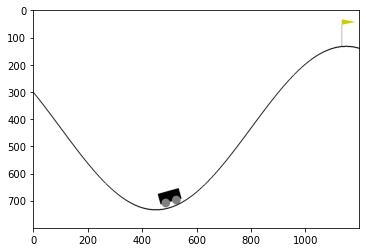

In [74]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


env = gym.make("MountainCar-v0").env
env.reset()

n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

print("state vector dim =", state_dim)
print("n_actions =", n_actions)

plt.imshow(env.render('rgb_array'))

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

In [75]:
def generate_session(env, agent, t_max=10000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s]).reshape((env.action_space.n,))

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(env.action_space.n, p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

def select_elites(states_batch, actions_batch, rewards_batch, percentile=20):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = []
    elite_actions = []
    
    for i, r in enumerate(rewards_batch):
        if r > reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])
            
    if len(elite_states) == 0:
        for i in range(len(rewards_batch)):
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])

    return elite_states, elite_actions

from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])
    
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()

In [27]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

mean reward = -129.840, threshold=-111.700


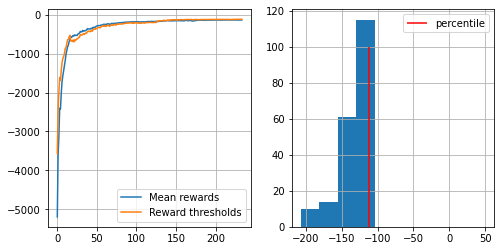

100%|███████████████████████████████████████████| 10/10 [00:48<00:00,  4.81s/it]


In [34]:
from tqdm import tqdm

n_sessions = 200
percentile = 70
# log = []

for i in tqdm(range(10)):
    # generate new sessions
    sessions = [generate_session(env, agent, 11500) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), 50])

In [37]:
print("Your average reward is", np.mean(rewards_batch))
if np.mean(rewards_batch) > -150:
    print("You Win! Average reward of at least -150 :)")
else:
    print("Try hard")

Your average reward is -129.84
You Win! Average reward of at least -150 :)


In [51]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("MountainCar-v0"), directory="videos_car_v1", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]

2022-02-20 16:58:27.489 python[4251:115822] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fef02cec9a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-02-20 16:58:27.489 python[4251:115822] Warning: Expected min height of view: (<NSButton: 0x7fef03081c30>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-02-20 16:58:27.492 python[4251:115822] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fef030bb0a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-02-20 16:58:27.494 python[4251:115822] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fef03099ca0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


In [52]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos_car_v1').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

  ### 2.2

In [77]:
from sklearn.neural_network import MLPClassifier

agent2 = MLPClassifier(
    hidden_layer_sizes=(32, 32),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent2.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(32, 32))

In [78]:
def generate_batch(env, *args, **kwargs):
    return generate_session(env, *args, **kwargs)

mean reward = -134.356, threshold=-109.000


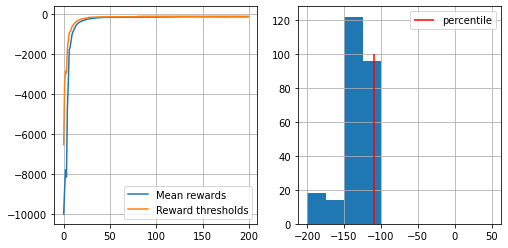

100%|█████████████████████████████████████████| 200/200 [35:46<00:00, 10.73s/it]


In [79]:
import itertools

from joblib import Parallel, delayed
from tqdm import tqdm

n_sessions = 250
percentile = 90
log2 = []

n_jobs = 10
envs = [gym.make("MountainCar-v0").env for _ in range(n_sessions)]

for i in tqdm(range(200)):
    sessions = [Parallel(n_jobs=n_jobs)(delayed(generate_batch)(envs[i], agent2, 11000) for i in range(len(envs)))]
    sessions = list(itertools.chain(*sessions))
    
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent2.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log2, percentile, reward_range=[np.min(rewards_batch), 50])

### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in Anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0) (90+ pts to solve), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) (200+ pts to solve) 
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules, aside from action spaces.